# Training sPHNN with synthetic data from a 2 mass oscillator
The sPHNN is trained with data from the following system:

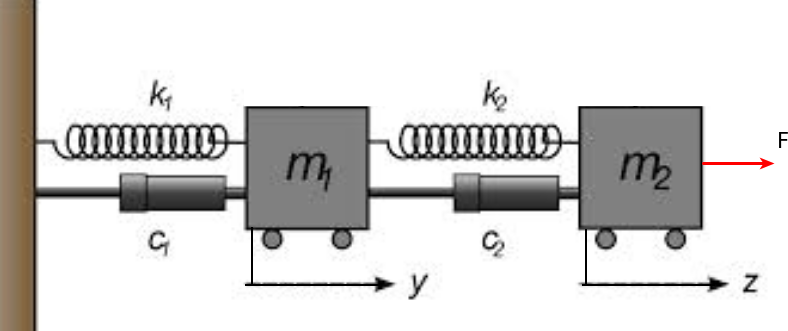

Note: I denote the state vector $\boldsymbol{y}=[q_1, q_2, v_1, v_2]^\intercal$ (would be $[y, z, \dot{y}, \dot{z}]^\intercal$ in the picture). And I use $d_i$ for the dampers and $u$ for the force instead of the $c_i$ and $F$ in the picture.

Imports

In [1]:
from dynax import ISPHS, ODESolver, LyapunovNN, aprbs
import klax

import equinox as eqx
from jaxtyping import Array
import jax
import jax.numpy as jnp
from jax import random as jr
from jax.nn.initializers import variance_scaling

import matplotlib.pyplot as plt

Define system and generate data

In [2]:
class Derivative(eqx.Module):
    """
    Derivative function of a linear two mass oscillator system, with a
    force input u acting on the second mass.
    """

    A: Array
    B: Array
    J: Array
    R: Array
    Q: Array

    def __init__(self, m1, m2, k1, k2, d1, d2):
        zeros = jnp.zeros((2, 2))

        # Structure matrix
        mass = jnp.array([[m1, 0], [0, m2]])
        mass_inv = jnp.linalg.inv(mass)
        J = jnp.block([[zeros, mass_inv], [-mass_inv, zeros]])
        self.J = J

        # Resistive matrix
        diss = jnp.array(
            [
                [(d1 + d2) / (m1 * m1), -d2 / (m1 * m2)],
                [-d2 / (m1 * m2), d2 / (m1 * m2)],
            ]
        )
        R = jnp.block([[zeros, zeros], [zeros, diss]])
        self.R = R

        # Hamililtonian quadratic form H=0.5xQx
        Q = jnp.array(
            [[k1 + k2, -k2, 0, 0], [-k2, k2, 0, 0], [0, 0, m1, 0], [0, 0, 0, m2]]
        )
        self.Q = Q

        self.A = (J - R) @ Q

        # Input matrix
        self.B = jnp.array([0, 0, 0, 1 / m2])[:, None]

    def __call__(self, t, y, u):
        return self.A @ y + self.B @ u

    def get_hamiltonian(self, y):
        """
        Returns the Hamiltonian H(x) = 0.5 * x^T Q x
        """
        return 0.5 * jnp.inner(y, self.Q @ y)


deriv = Derivative(m1=1, m2=2, k1=5, k2=2, d1=0.1, d2=0.1)
true_system = eqx.filter_jit(ODESolver(deriv))

key = jr.key(0)
data_key, model_key, loader_key = jr.split(key, 3)

state_size = 4
num_ts = 200
num_trajs = 10
ts = jnp.linspace(0.0, 25.0, num_ts)
y0s = jr.uniform(data_key, (num_trajs, state_size))
us_ = jax.vmap(aprbs, in_axes=(0, None, None))(jr.split(data_key, num_trajs), num_ts, 3)
us = 1 - 2 * us_[:, :, None]
ys = jax.vmap(true_system, in_axes=(None, 0, 0))(ts, y0s, us)

Define model

In [3]:
ficnn = klax.nn.FICNN(
    in_size=state_size,
    out_size="scalar",
    width_sizes=[16, 16],
    key=model_key,
)
hamiltonian = LyapunovNN(ficnn, state_size=state_size, key=model_key)
poisson_matrix = klax.nn.ConstantSkewSymmetricMatrix(
    state_size,
    init=variance_scaling(5, "fan_avg", "truncated_normal"),
    key=model_key,
)
resistive_matrix = klax.nn.ConstantSPDMatrix(
    state_size,
    epsilon=0.0,
    init=variance_scaling(0.1, "fan_avg", "truncated_normal"),
    key=model_key,
)
input_matrix = klax.nn.ConstantMatrix(
    (state_size, 1),
    init=variance_scaling(0.0001, "fan_avg", "truncated_normal"),
    key=model_key,
)
deriv_model = ISPHS(hamiltonian, poisson_matrix, resistive_matrix, input_matrix)
model = ODESolver(deriv_model)

Train or load model parameters

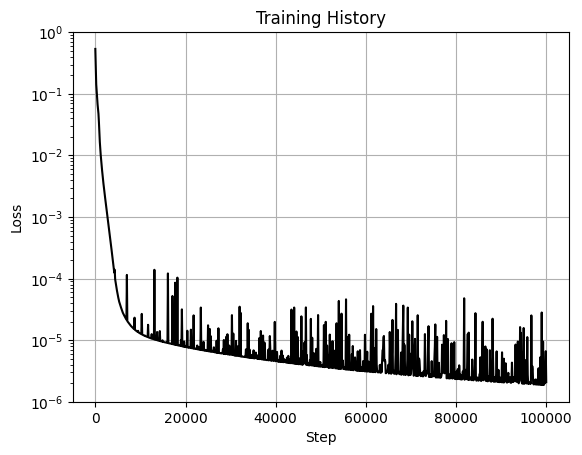

In [10]:
try:
    # Loading the model and history
    model = eqx.tree_deserialise_leaves("two_mass_oscillator_model.eqx", model)
    hist = klax.HistoryCallback.load("two_mass_oscillator_hist.pkl")
except FileNotFoundError:

    def loss_fn(model, data, batch_axis):
        ts, ys, us = data
        ys_pred = jax.vmap(model, in_axes=batch_axis)(ts, ys[:, 0], us)
        return jnp.mean(jnp.square(ys_pred - ys))

    model, hist = klax.fit(
        model,
        (ts, ys, us),
        batch_axis=(None, 0, 0),
        steps=100_000,
        loss_fn=loss_fn,
        key=model_key,
    )

    hist.save("two_mass_oscillator_hist.pkl")
    eqx.tree_serialise_leaves("two_mass_oscillator_model.eqx", model)

finalized_model = klax.finalize(model)
jitted_model = eqx.filter_jit(finalized_model)
_ = jitted_model(ts, y0s[0], us[0])  # Call once to compile

hist.plot()

Plot a test prediction

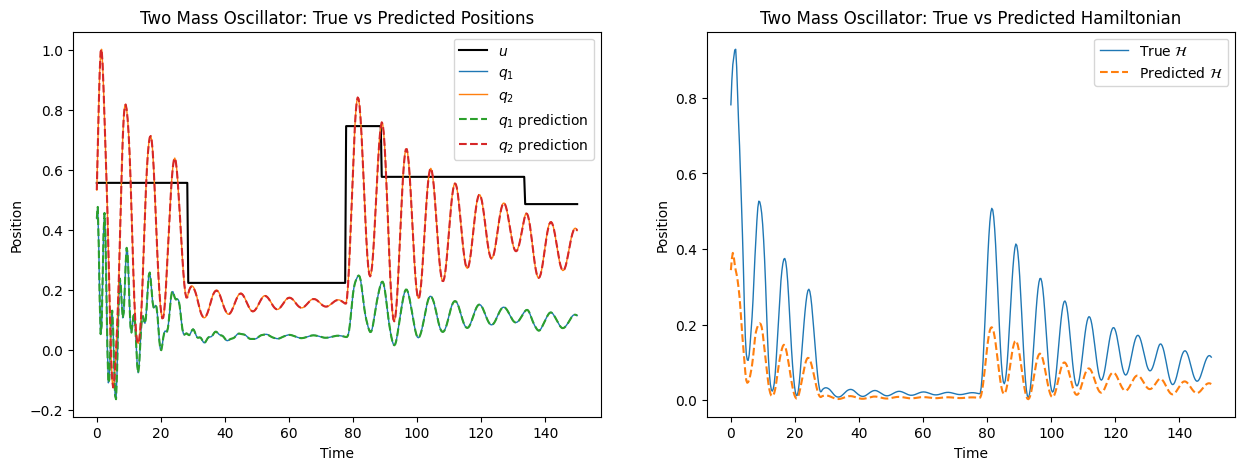

In [13]:
test_key = jr.key(1)

test_ts = jnp.linspace(0.0, 150.0, 500)
u = aprbs(test_key, test_ts.size, 4)[:, None]
y0 = jr.uniform(test_key, (state_size,))
ys_true = true_system(test_ts, y0, u)
ys_pred = jitted_model(test_ts, y0, u)

Hs_true = jax.vmap(deriv.get_hamiltonian)(ys_true)
Hs_pred = jax.vmap(finalized_model.func.hamiltonian)(ys_true)

fix, axes = plt.subplots(1, 2, figsize=(15, 5))
ax = axes[0]
ax.plot(test_ts, u, label="$u$", c="black")
ax.plot(test_ts, ys_true[:, :2], label=["$q_1$", "$q_2$"], lw=1)
ax.plot(test_ts, ys_pred[:, :2], "--", label=["$q_1$ prediction", "$q_2$ prediction"])
ax.set(
    xlabel="Time",
    ylabel="Position",
    title="Two Mass Oscillator: True vs Predicted Positions",
)
ax.legend()

ax = axes[1]
ax.plot(test_ts, Hs_true, label=R"True $\mathcal{H}$", lw=1)
ax.plot(test_ts, Hs_pred, "--", label=R"Predicted $\mathcal{H}$")
ax.set(
    xlabel="Time",
    ylabel="Position",
    title="Two Mass Oscillator: True vs Predicted Hamiltonian",
)
ax.legend()

plt.show()

## Explaination of the differences in the Hamiltonians
The true system and the model are of port-Hamiltonian form, relating the current state $\boldsymbol{y}$ and the input force $\boldsymbol{u}$ to the state derivative:
$
\begin{equation}
    \dot{\boldsymbol{y}} = (\boldsymbol{J} - \boldsymbol{R})\frac{\partial\mathcal{H}}{\partial\boldsymbol{y}} + \boldsymbol{G}\boldsymbol{u}
\end{equation}
$
with constant structure, dissipation and imput matrices $\boldsymbol{J}, \boldsymbol{R}$ and $\boldsymbol{G}$, as well as Hamiltonian $\mathcal{H}$.

The above equation allows different Hamiltonians to lead to the same dynamics. If the learned model exactly reproduces the true systems dynamics, the learned Hamiltonian $\tilde{\mathcal{H}}$ may still differ from the true Hamiltonian $\mathcal{H}$ by a constant factor $c_1(\boldsymbol{y})\in\mathbb{R}\setminus\{0\}$ and offset $c_2(\boldsymbol{y})\in\mathbb{R}\setminus\{0\}$:
$
\begin{equation}
    \tilde{\mathcal{H}} = c_1\mathcal{H} + c_2.
\end{equation}
$
The factor $c_1$ is then absorbed by the learned matrices $\tilde{\boldsymbol{J}}=\frac{1}{c_1}\boldsymbol{J}, \tilde{\boldsymbol{R}}=\frac{1}{c_1}\boldsymbol{R}$, while the constant offset does not impact the dynamics, since it is only impacted by the gradient of the Hamiltonian.

It is therefore unlikely, that a learned port-Hamiltonian system has identified the "true" Hamiltonian. To verify the shape of the learned Hamiltonian, one can rescale and offset it to best fit the ground truth Hamiltonian. This is done in the next code cell.

Note that if the matrices $\boldsymbol{J}, \boldsymbol{R}$ are not state dependent then $c_1, c_2$ are just constants. They can then be found by a least squares fit.


In [ ]:
# Construct least squares problem for finding c1 and c2
a = jnp.stack([Hs_true, jnp.ones_like(Hs_true)], axis=1)
b = Hs_pred
(c1, c2), residuals, _, _ = jnp.linalg.lstsq(a, b)
print("MSE of the Hamiltonian prediction (invariance accounted):", residuals / Hs_true.size)

MSE of the Hamiltonian prediction (invariance accounted): [2.1551372e-05]


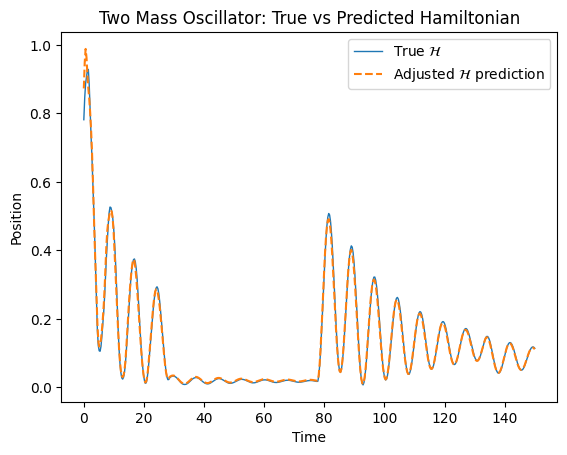

In [24]:
fix, ax = plt.subplots()
Hs_pred_accounted = (Hs_pred - c2) / c1
ax.plot(test_ts, Hs_true, label=R"True $\mathcal{H}$", lw=1)
ax.plot(test_ts, Hs_pred_accounted, "--", label=R"Adjusted $\mathcal{H}$ prediction")
ax.set(
    xlabel="Time",
    ylabel="Position",
    title="Two Mass Oscillator: True vs Predicted Hamiltonian",
)
ax.legend()

plt.show()